CSV guardado → posiciones.csv


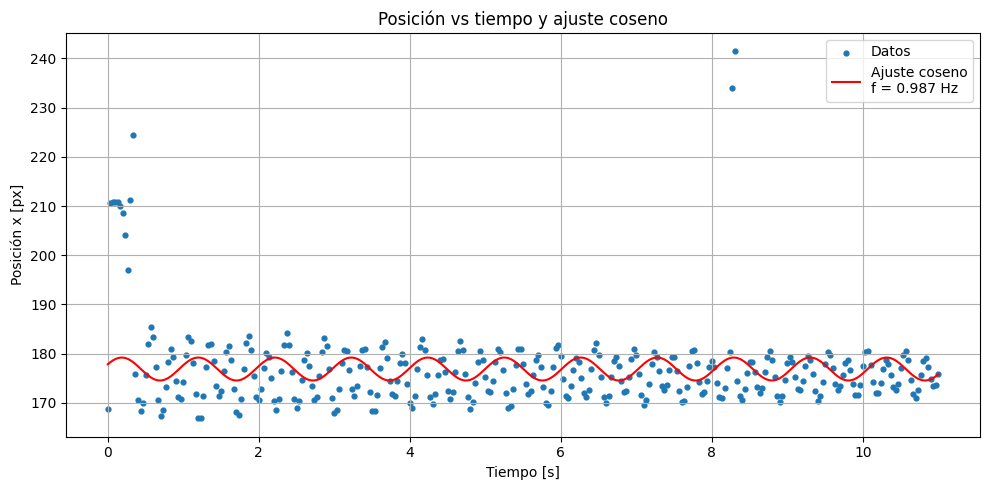

Gráfico guardado → ajuste_coseno.png
Frecuencia estimada: 0.9872 Hz
perioodo: 1.0130014187396912


In [3]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# -------------------------------------------------
# PARÁMETROS BÁSICOS
# -------------------------------------------------
VIDEO_PATH   = "video_filtrado.mp4"   # ← tu video ya filtrado
FPS          = 30                     # cuadros por segundo
CSV_OUT      = "posiciones.csv"
FIG_OUT      = "ajuste_coseno.png"

# -------------------------------------------------
# FUNCIÓN DE AJUSTE (COSENO)
# x(t) = A cos(ω t + φ) + x0
# -------------------------------------------------
def coseno(t, A, omega, phi, x0):
    return A * np.cos(omega * t + phi) + x0

# -------------------------------------------------
# EXTRACCIÓN DE POSICIONES
# -------------------------------------------------
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise IOError(f"No pude abrir {VIDEO_PATH}")

datos = []             # [(tiempo, x_pos)]
frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # El video ya está filtrado: buscamos los píxeles "no negros"
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)   # 10 ≈ umbral anti-ruido
    conts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL,
                                 cv2.CHAIN_APPROX_SIMPLE)

    if conts:
        c = max(conts, key=cv2.contourArea)
        M = cv2.moments(c)
        if M["m00"] > 0:
            cx = M["m10"] / M["m00"]          # coordenada x del centroide
            t  = frame_idx / FPS
            datos.append((t, cx))

    frame_idx += 1

cap.release()

# -------------------------------------------------
# GUARDAR CSV
# -------------------------------------------------
df = pd.DataFrame(datos, columns=["tiempo_s", "pos_x_px"])
df.to_csv(CSV_OUT, index=False)
print(f"CSV guardado → {CSV_OUT}")

# -------------------------------------------------
# AJUSTE COSENO
# -------------------------------------------------
t = df["tiempo_s"].values
x = df["pos_x_px"].values

# estimaciones iniciales
A0     = (x.max() - x.min()) / 2
omega0 = 2 * np.pi * 1.0            # ≈ 1 Hz
phi0   = 0.0
x00    = x.mean()
p0     = [A0, omega0, phi0, x00]

params, _ = curve_fit(coseno, t, x, p0=p0)
A, omega, phi, x0 = params
frec = omega / (2 * np.pi)

# -------------------------------------------------
# GRÁFICA
# -------------------------------------------------
plt.figure(figsize=(10, 5))
plt.scatter(t, x, s=12, label="Datos")
plt.plot(t, coseno(t, *params), c="red",
         label=f"Ajuste coseno\nf = {frec:.3f} Hz")
plt.xlabel("Tiempo [s]")
plt.ylabel("Posición x [px]")
plt.title("Posición vs tiempo y ajuste coseno")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(FIG_OUT, dpi=300)
plt.show()

print(f"Gráfico guardado → {FIG_OUT}")
print(f"Frecuencia estimada: {frec:.4f} Hz")
print(f'perioodo: {frec**-1}')